In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
path = "dataset"

In [35]:
class_labels = sorted(os.listdir(path))
class_labels

['with_mask', 'without_mask']

In [36]:
image_counts = {label: len(os.listdir(os.path.join(path, label))) for label in class_labels}
df = pd.DataFrame(list(image_counts.items()), columns=["Class", "Number of Images"])
print(df)

          Class  Number of Images
0     with_mask              2165
1  without_mask              1930


In [37]:
def showimages(dataset_path, class_labels, samples):
    fig, axes = plt.subplots(len(class_labels), samples, figsize=(samples * 3, len(class_labels) * 3))

    for i, label in enumerate(class_labels):
        class_path = os.path.join(dataset_path, label)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, min(samples, len(image_files)))

        for j, img_file in enumerate(random_images):
            img_path = os.path.join(class_path, img_file)
            image = Image.open(img_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"{label}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

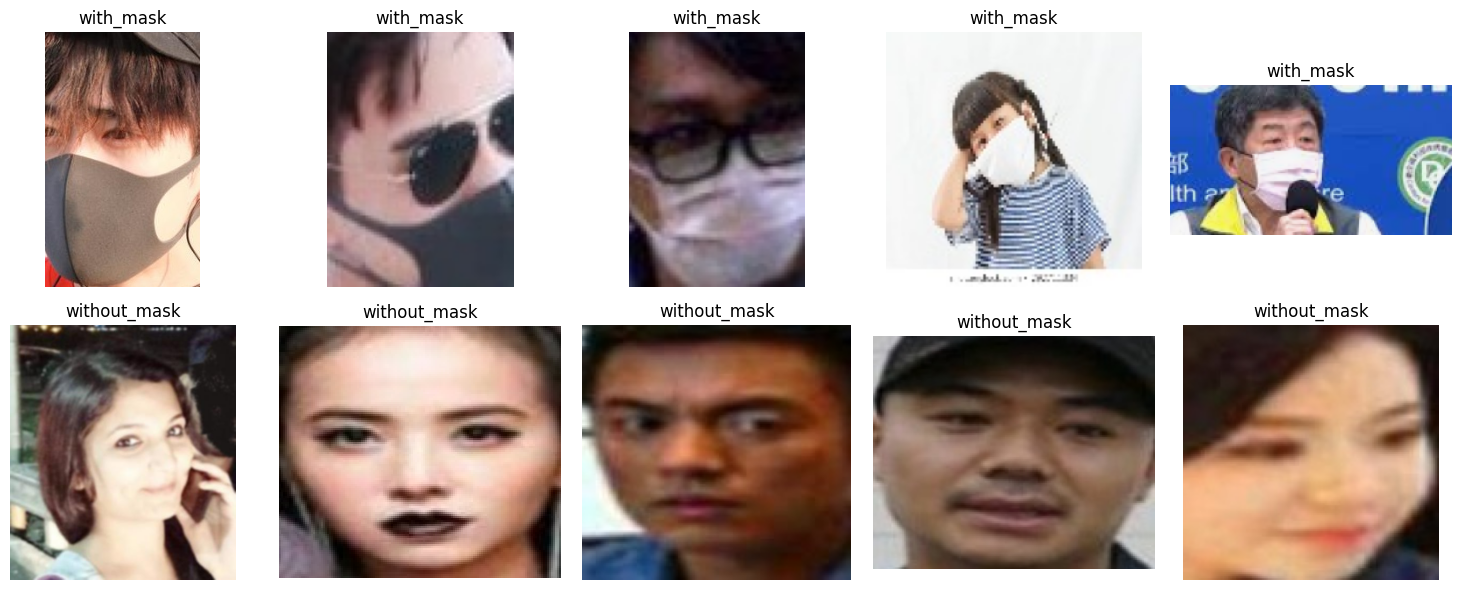

In [38]:
showimages(path, class_labels, samples=5)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
device

device(type='cuda')

In [41]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [43]:
model = CNN().to(device)

loss_fun = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [45]:
def train(model, loss_fun, optimizer, epochs, suppress=False):
    loss_list = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            loss = loss_fun(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))

        if suppress == False:
            print(f"Epoch: {epoch+1:<2} | Train Loss: {running_loss/len(train_loader):<10.5f}")
    return loss_list

In [46]:
loss_list = train(model, loss_fun, optimizer, epochs=10)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1  | Train Loss: 0.41242   
Epoch: 2  | Train Loss: 0.28134   
Epoch: 3  | Train Loss: 0.22790   
Epoch: 4  | Train Loss: 0.19681   
Epoch: 5  | Train Loss: 0.17420   
Epoch: 6  | Train Loss: 0.16097   
Epoch: 7  | Train Loss: 0.12542   
Epoch: 8  | Train Loss: 0.11236   
Epoch: 9  | Train Loss: 0.10507   
Epoch: 10 | Train Loss: 0.09338   


In [47]:
def accuracy(model, loader, device):
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            predictions = torch.round(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    return round(accuracy_score(y_true, y_pred) * 100, 2), y_true, y_pred

In [48]:
def plot_loss(loss_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-', color='b', label="Train Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

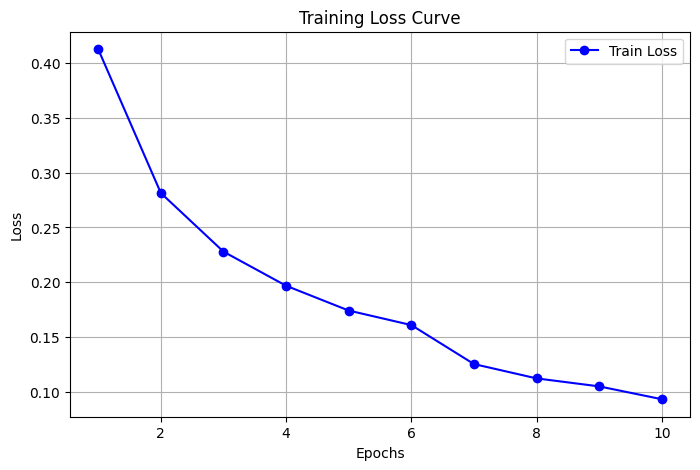

In [49]:
plot_loss(loss_list)

In [50]:
test_accuracy, y_true, y_pred  = accuracy(model,test_loader,device)
train_accuracy, _, _ = accuracy(model,train_loader,device)
auc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Train Accuracy : {train_accuracy}%")
print(f"Test Accuracy : {test_accuracy}% | AUC : {auc:.4f} | F1-Score : {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Accuracy : 96.61%
Test Accuracy : 95.24% | AUC : 0.9510 | F1-Score : 0.9471


In [51]:
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[431  15]
 [ 24 349]]


In [52]:
def predict_random_images(model, test_dataset, num_images=5):
    model.eval()
    num_images = min(num_images, len(test_dataset))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        idx = random.randint(0, len(test_dataset) - 1)
        image, label = test_dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor).squeeze().item()

        predicted_label = 'Without Mask' if output > 0.5 else 'With Mask'
        tlabel = 'Without Mask' if label == 1 else 'With Mask'

        img = image.cpu().permute(1, 2, 0).numpy()
        img = img.clip(0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {tlabel}\nPred: {predicted_label}", fontsize=12)

    plt.tight_layout()
    plt.show()


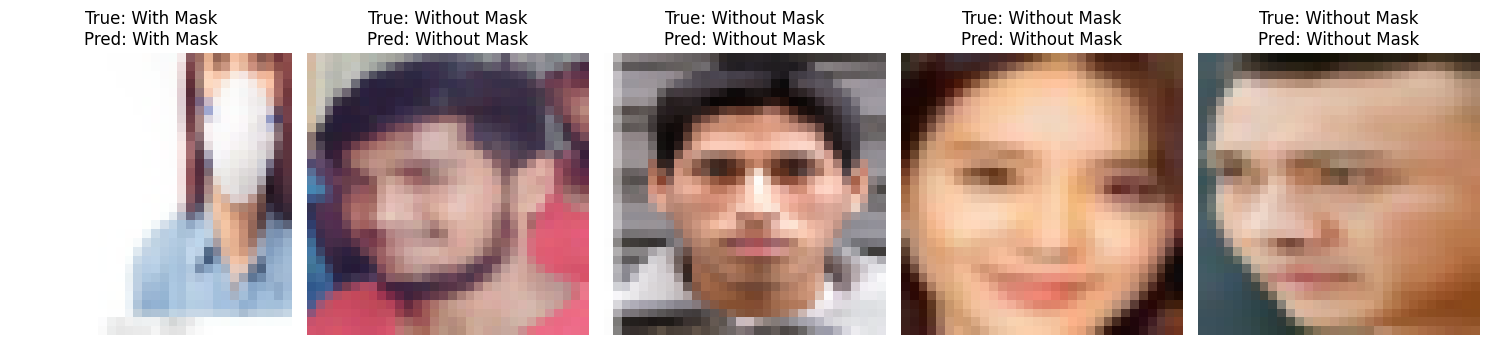

In [53]:
predict_random_images(model, test_dataset, num_images=5)

In [54]:
import itertools

def run_experiments():
    results = []

    learning_rates = [0.01, 0.02]
    optimizers = ['adam', 'sgd']
    epochs_list = [10, 15, 20]

    param_combinations = list(itertools.product(learning_rates, optimizers, epochs_list))

    for lr, opt, epochs in param_combinations:

        model = CNN().to(device)

        loss_fun = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train model
        loss_list = train(model, loss_fun, optimizer, epochs=epochs, suppress=True)

        # Evaluate model
        test_accuracy, y_true, y_pred = accuracy(model, test_loader, device)
        train_accuracy, _, _ = accuracy(model, train_loader, device)
        auc = roc_auc_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        results.append({
            'learning_rate': lr,
            'optimizer': opt,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'auc': auc,
            'f1_score': f1,
            'loss_list': loss_list ,
            "epochs":epochs
        })

    return results

In [55]:
experiment_results = run_experiments()

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

In [61]:
new_result = {
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'train_accuracy': 96.61,
    'test_accuracy': 95.24,
    'auc': 0.9510,
    'f1_score': 0.9471,
    'loss_list': loss_list ,
    'epochs': 10
}
experiment_results.insert(0, new_result)

In [62]:
from tabulate import tabulate

df = pd.DataFrame(experiment_results)

df_filtered = df.drop(columns=['loss_list'])

print(tabulate(df_filtered, headers='keys', tablefmt='pretty'))

+----+---------------+-----------+----------------+---------------+--------------------+--------------------+--------+
|    | learning_rate | optimizer | train_accuracy | test_accuracy |        auc         |      f1_score      | epochs |
+----+---------------+-----------+----------------+---------------+--------------------+--------------------+--------+
| 0  |     0.001     |   adam    |     96.61      |     95.24     |       0.951        |       0.9471       |   10   |
| 1  |     0.01      |   adam    |     90.78      |     91.21     | 0.9162108224431648 | 0.9088607594936708 |   10   |
| 2  |     0.01      |   adam    |      98.5      |     94.26     | 0.9429212902295051 | 0.9375830013280213 |   15   |
| 3  |     0.01      |   adam    |      98.6      |     94.26     | 0.9429212902295051 | 0.9375830013280213 |   20   |
| 4  |     0.01      |    sgd    |     91.85      |     89.5      | 0.8974440664109933 | 0.8891752577319587 |   10   |
| 5  |     0.01      |    sgd    |     96.03    

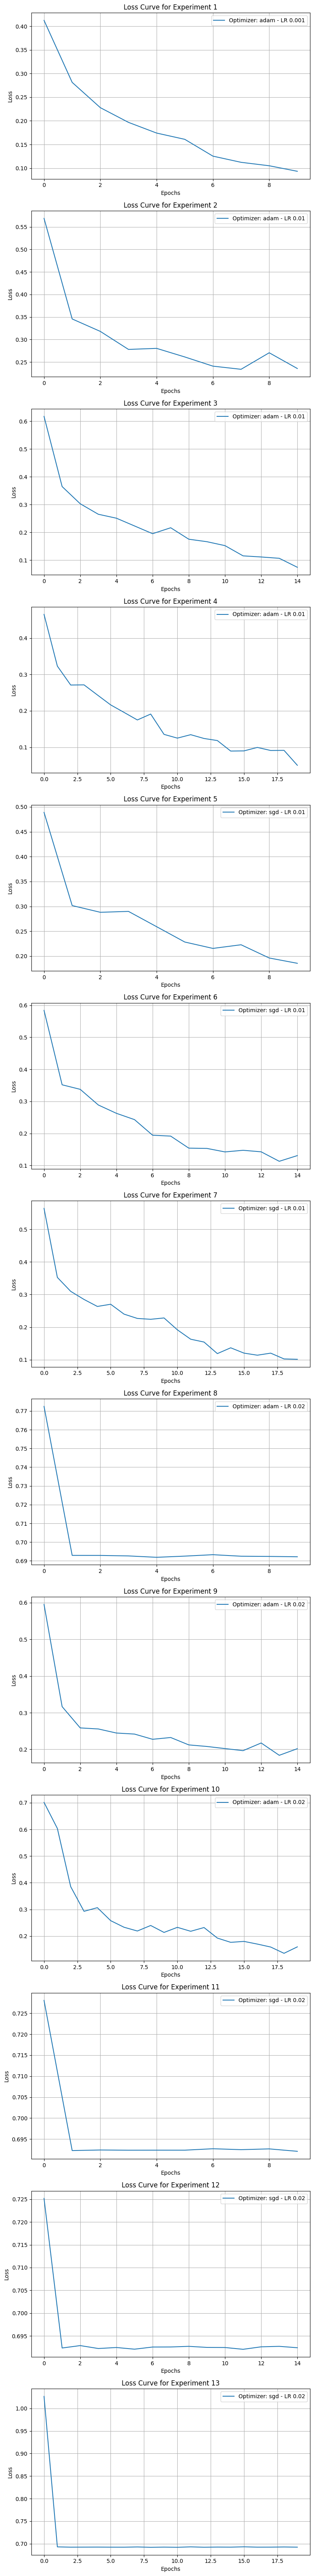

In [67]:
num_experiments = len(experiment_results)
fig, axes = plt.subplots(num_experiments, 1, figsize=(8, 5 * num_experiments))
if num_experiments == 1:
    axes = [axes]

for idx, exp in enumerate(experiment_results):
    loss_list = exp['loss_list']
    ax = axes[idx]

    ax.plot(loss_list, label=f"Optimizer: {exp['optimizer']} - LR {exp['learning_rate']}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss Curve for Experiment {idx+1}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
